In [37]:
from sklearn.svm import LinearSVC
from common_functions import *

PATH = "../datasets/Diabete"
diabete_dataset = load_housing_data(PATH, "datasets_diabetes.csv")

In [38]:
diabete_dataset.info()
X = diabete_dataset[['Glucose', 'Age']]
y = diabete_dataset[['Outcome']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X_train['Glucose'].value_counts()

99     16
100    15
125    13
129    12
108    12
       ..
198     1
150     1
149     1
135     1
199     1
Name: Glucose, Length: 133, dtype: int64

<class 'pandas.core.frame.DataFrame'>


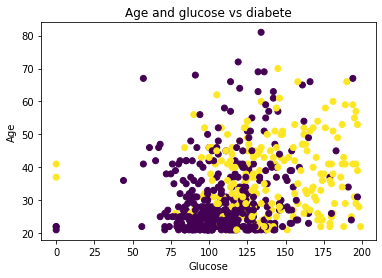

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_dataset(X, y):
    print(type(X))
    plt.scatter(X.values[:, 0], X.values[:, 1], c = y.values[:,0])
    plt.ylabel('Age')
    plt.xlabel('Glucose')
    plt.title('Age and glucose vs diabete')
    
# X_train
var = X_train.to_numpy()
plot_dataset(X_train, y_train)
plt.show()
    